In [1]:
QRY_PATH="/home/global/anaconda2/tract_querier/queries/freesurfer_queries.qry"
#SUBJ_ID="T02S01"
SUBJ_ID="p_DG21_a"
NAS="tupac"
#protocole="healthy_volunteers"
protocole="alexcis"
DIR_PATH="/NAS/"+NAS+"/protocoles/"+protocole
FS_PATH=DIR_PATH+"/FS53/"
DTI_PATH=FS_PATH+SUBJ_ID+"/dti/"
TRACTO="whole_brain_6_1500000"
#SEG = DTI_PATH+"raparc+aseg.nii"
SEG = DTI_PATH+"raparc.a2009s+aseg.nii"
MESH = "lh.white.ras"

In [2]:
from nibabel import trackvis as tv
from dipy.viz import fvtk
from dipy.segment.metric import ResampleFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.segment.metric import CenterOfMassFeature
from dipy.segment.metric import EuclideanMetric
from dipy.segment.metric import IdentityFeature
from dipy.segment.clustering import QuickBundles
from dipy.io.image import load_nifti, save_nifti
from dipy.tracking.streamline import set_number_of_points

from dipy.tracking import utils

from nibabel import freesurfer as fs
from dipy.utils.optpkg import optional_package
import dipy.io.vtk as io_vtk
import dipy.viz.utils as ut_vtk
from dipy.viz import window, actor, ui
from dipy.tracking import utils
import nipype.interfaces.mrtrix as mrt
from dipy.tracking.streamline import select_random_set_of_streamlines
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import random
from dipy.tracking.streamline import transform_streamlines
from dipy.denoise.enhancement_kernel import EnhancementKernel
from dipy.tracking.fbcmeasures import FBCMeasures
from nibabel.streamlines import Field
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
from dipy.viz import colormap
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
#labelconvert dti/aparc.a2009s+aseg.nii /home/global//freesurfer6_0//FreeSurferColorLUT.txt /home/global/mrtrix3_RC2/mrtrix3/share/mrtrix3/labelconvert/fs_default.txt dti/label.nii.gz
bundle = nib.streamlines.load(FS_PATH+"p_AR28_na/bundle_cc_4.trk")
data, affine = load_nifti(FS_PATH+"p_AR28_na/dti/dti.nii.gz")
#label, affineLabel = load_nifti(FS_PATH+"p_AR28_na/dti/label.nii.gz")
label, affineLabel = load_nifti(FS_PATH+"p_AR28_na/dti/aparc.a2009s+aseg.nii")

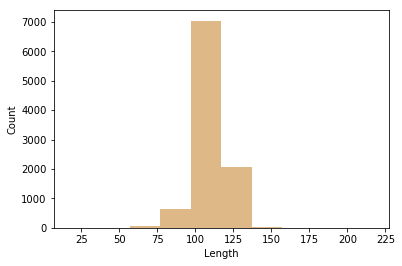

/home/global/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [4]:
#print(bundle.affine)
#trk_shifted = transform_streamlines(trk4.tractogram.streamlines,np.linalg.inv(affine))
lengths = list(utils.length(bundle.tractogram.streamlines))
#print(lengths)
fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood')
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()
plt.legend()

In [46]:
test = utils.density_map(trk4.tractogram.streamlines,data.shape[0:3],affine=affine)
#save_nifti(FS_PATH+"p_AR28_na/density_map.nii.gz",test, affine)
dm_img = nib.Nifti1Image(test.astype("int16"),affine)
dm_img.to_filename(FS_PATH+"p_AR28_na/density_map.nii.gz")

In [54]:
feature = ResampleFeature(nb_points=24)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=100, metric=metric)
qb.max_nb_clusters = 1
cluster = qb.cluster(trk4.tractogram.streamlines)

In [57]:
print("Nb. clusters:", len(cluster))
print("Cluster sizes:", map(len, cluster))
clus=list(cluster.centroids)
print(clus)

('Nb. clusters:', 1)
('Cluster sizes:', [9851])
[array([[ 28.1553421 , -10.45228195,  52.32127762],
       [ 26.67933846, -10.64287853,  48.97660065],
       [ 25.08213234, -10.36063957,  45.59922028],
       [ 23.66619682,  -9.91308784,  42.27915955],
       [ 22.40568352,  -9.38051605,  38.93884277],
       [ 21.021492  ,  -8.67530537,  35.61710739],
       [ 19.16176224,  -7.92659044,  32.29608536],
       [ 16.65177917,  -7.20066881,  29.03641701],
       [ 13.51764107,  -6.55988312,  26.03774071],
       [  9.86507511,  -6.05448627,  23.46230698],
       [  5.81796503,  -5.68745422,  21.48469543],
       [  1.45281267,  -5.54299116,  20.43599319],
       [ -2.99236274,  -5.88275242,  20.54062653],
       [ -7.25824642,  -6.73351765,  21.66708374],
       [-11.22260094,  -7.81360054,  23.45122528],
       [-14.9135828 ,  -8.8866148 ,  25.53538322],
       [-18.24248695,  -9.93323612,  27.74658966],
       [-21.00098038, -11.06754875,  30.14574051],
       [-23.08922386, -12.1330814

In [69]:
r = fvtk.ren()
#test = utils.density_map(trk4.tractogram.streamlines,data.shape[0:3],affine=affine)
#bundle_native = transform_streamlines(trk4.tractogram.streamlines,np.linalg.inv(affine))
#fvtk.add(r, actor.line(bundle_native,test,linewidth=0.1,opacity=0.3));
fvtk.add(r, actor.line(trk4.tractogram.streamlines,linewidth=0.1,opacity=0.3));

bar = actor.scalar_bar()
fvtk.add(r,bar)
a=fvtk.axes()
fvtk.add(r,a)

#fvtk.add(r,fvtk.streamtube(trk3.streamlines,raparc.get,linewidth=1))

#fvtk.add(r, actor.line(fbc_sl_orig, clrs_orig, linewidth=0.2))
#fvtk.add(r, actor.line(fbc_sl_thres, clrs_thres, linewidth=0.2))
fvtk.show(r)

In [53]:
#M, grouping = 
utils.connectivity_matrix(trk4.tractogram.streamlines,labels,affine=affine)
                          #,return_mapping=True,mapping_as_streamlines=True)
#M[:3, :] = 0
#M[:, :3] = 0

IndexError: index 88 is out of bounds for axis 0 with size 81